In [1]:
import torch 
import torch.nn as nn
from torch.nn import TransformerEncoderLayer, TransformerEncoder
import numpy as np
import pandas as pd

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
        

In [4]:

class BTCTransformer(nn.Module):
    def __init__(self, input_features = 5,
                 d_model = 256,
                 nhead = 8,
                 num_encoder_layers = 6,
                 dim_feedforward = 1024,
                 dropout = 0.1,
                 sequence_length = 168,
                 activation = 'gelu'
                 ):
        super().__init__()
        self.sequence_length = sequence_length
        self.input_embedding = nn.Linear(input_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len=sequence_length)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        
        self.transformer_encoder = TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128,64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64,1)
        )
    
    def forward(self,x):
        
        x = self.input_embedding(x)
        x = self.pos_encoder(x)
        transformer_out = self.transformer_encoder(x)
        last_hidden = transformer_out[:,-1,:]
        out = self.decoder(last_hidden)
        return out
    

In [5]:
def preprocess_data(df, sequence_length = 168):
    
    features = ['open', 'high', 'low', 'close', "volume"]
    normalized_data = {}
    
    for feature in features:
        min_val = df[feature].min()
        max_val = df[feature].max()
        normalized_data[feature] = (df[feature] - min_val) / (max_val - min_val)

    X, y = [], []
    data = np.column_stack([normalized_data[f] for f in features])
    
    for i in range(len(df) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(normalized_data['close'][i + sequence_length])
    
    return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)


In [5]:
device = "mps"

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


            
def train_transformer(model, train_data, val_data, 
                     batch_size=32, 
                     epochs=300,  # Increased epochs
                     learning_rate=0.0001,
                     device='mps' if torch.backends.mps.is_available() else 'cpu'):
    
    print(f"Using device: {device}")
    model = model.to(device)
    
    train_loader = DataLoader(TensorDataset(train_data[0], train_data[1]), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data[0], val_data[1]), batch_size=batch_size)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True)
    criterion = nn.MSELoss()
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_batches = 0, 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
        
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            pbar.set_postfix({'training_loss': train_loss/train_batches})
        
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss, val_batches = 0, 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch + 1}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}')
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}

def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_losses'], label='Training Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
data = pd.read_csv('/Users/anuragprasad/Documents/btc_eth/Transformers_BTC_price_predictoin/data_hr.csv')
df = pd.DataFrame(data)

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [8]:
df.set_index('datetime', inplace=True)

In [9]:
df = df.drop(columns=['Unnamed: 0'])

In [10]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

In [ ]:

def main(df):
    
    X, y = preprocess_data(df, sequence_length=168)

    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    train_X, train_y = X[:train_size], y[:train_size]
    val_X, val_y = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    test_X, test_y = X[train_size+val_size:], y[train_size+val_size:]
    
    model = BTCTransformer()
    model.to('mps')
    trained_model, history = train_transformer(
        model=model,
        train_data=(train_X, train_y),
        val_data=(val_X, val_y),
        batch_size=32,
        epochs=50,
        learning_rate=0.0001
    )

    plot_training_history(history)
    
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'training_history': history
    }, 'btc_transformer_model.pth')

In [ ]:
main(df)

In [14]:
df

,open,high,low,close,volume
datetime,,,,,
2019-09-08 17:00:00,10000.00,10000.00,10000.00,10000.00,0.002
2019-09-08 18:00:00,10000.00,10000.00,10000.00,10000.00,0.000
2019-09-08 19:00:00,10344.77,10357.53,10337.43,10340.12,471.659
2019-09-08 20:00:00,10340.12,10368.64,10334.54,10351.42,583.271
2019-09-08 21:00:00,10351.42,10391.90,10324.77,10391.90,689.759
...,...,...,...,...,...
2023-12-31 20:00:00,42659.90,42724.50,42543.30,42599.10,4730.936
2023-12-31 21:00:00,42599.20,42717.00,42558.20,42558.90,3794.010
2023-12-31 22:00:00,42559.00,42629.50,42111.90,42294.80,11952.346


In [13]:

model = BTCTransformer()
checkpoint = torch.load("model.pth")
model.load_state_dict(checkpoint["model_state_dict"])


<All keys matched successfully>

In [14]:
X, y = preprocess_data(df, sequence_length=168)

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
train_X, train_y = X[:train_size], y[:train_size]
val_X, val_y = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
test_X, test_y = X[train_size+val_size:], y[train_size+val_size:]

/var/folders/57/_28h87h91hb15nq_3f30q0th0000gn/T/ipykernel_98462/2439818838.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(normalized_data['close'][i + sequence_length])
/var/folders/57/_28h87h91hb15nq_3f30q0th0000gn/T/ipykernel_98462/2439818838.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)


In [15]:
test_X = test_X[:800]
test_y = test_y[:800]

In [17]:
test_X,test_y = test_X.to('mps'),test_y.to('mps')

In [19]:
model = model.to("mps")

In [20]:
with torch.no_grad():
    y_pred = model(test_X)


In [21]:
y_pred = y_pred.cpu().numpy().flatten()
y_test = test_y.cpu().numpy().flatten()

In [22]:
len(y_pred), len(y_test)

(800, 800)

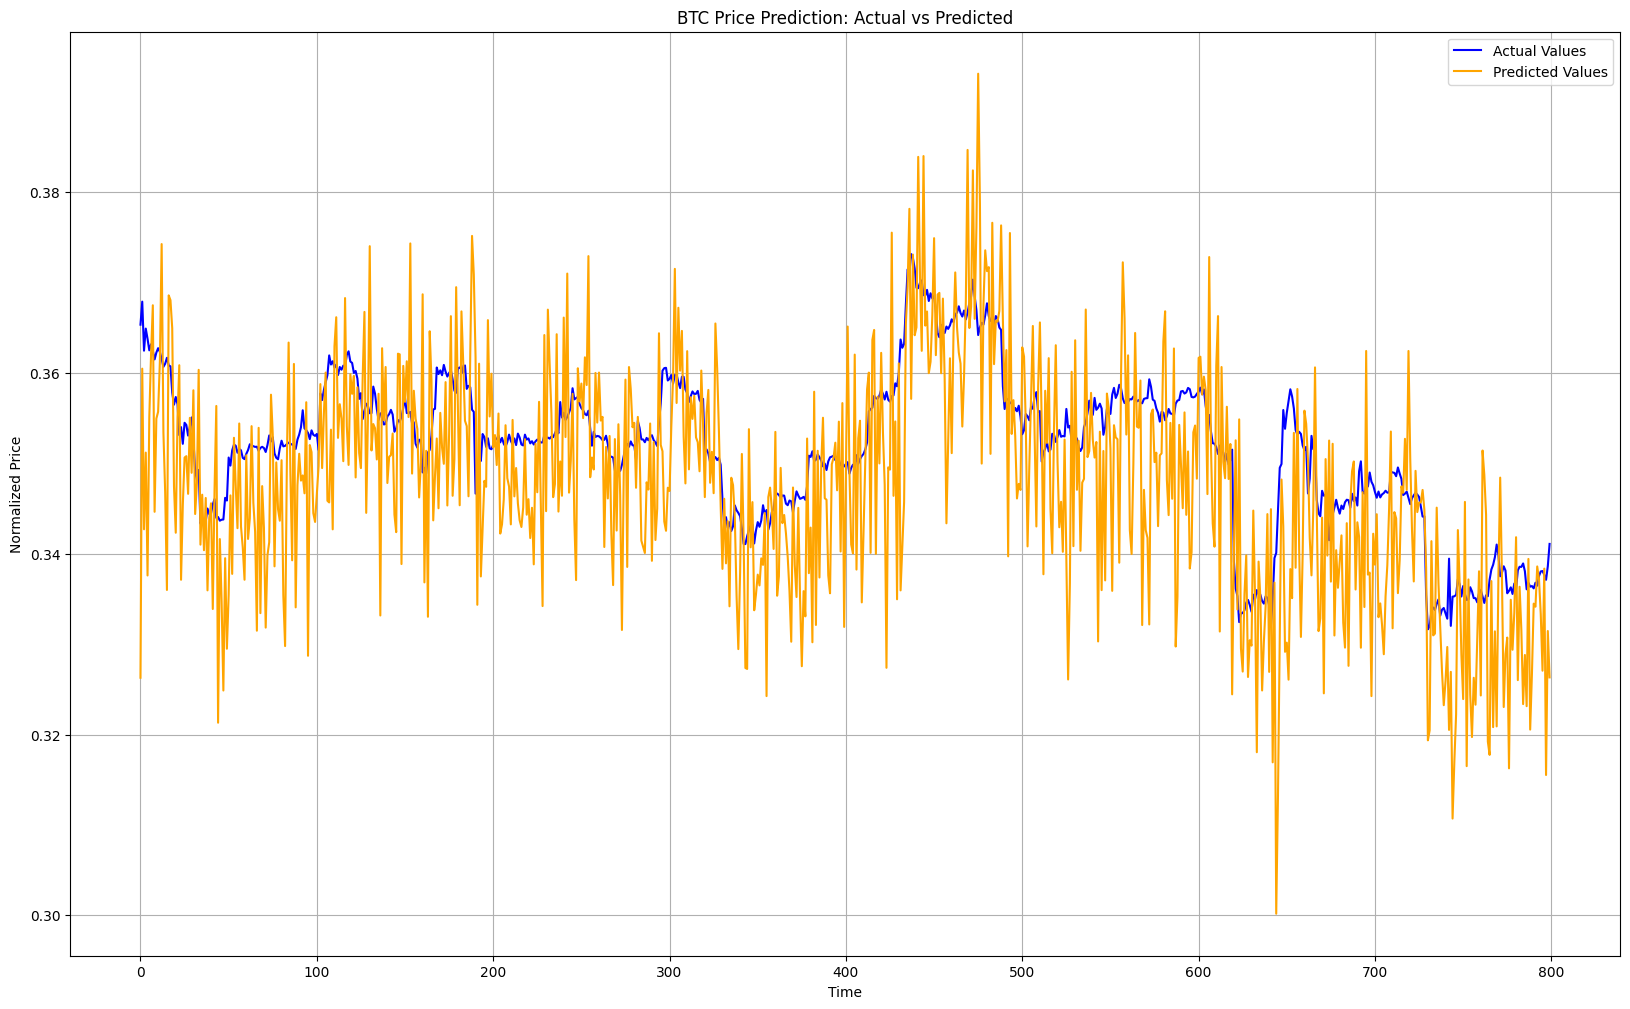

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.plot(y_test, label="Actual Values", color="blue")
plt.plot(y_pred, label="Predicted Values", color="orange")
plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.title("BTC Price Prediction: Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()


In [ ]:
window_size = 15
smoothedned_y_pred = pd.Series(y_pred).rolling(window=window_size).mean()


In [30]:
len(smoothedned_y_pred)

800

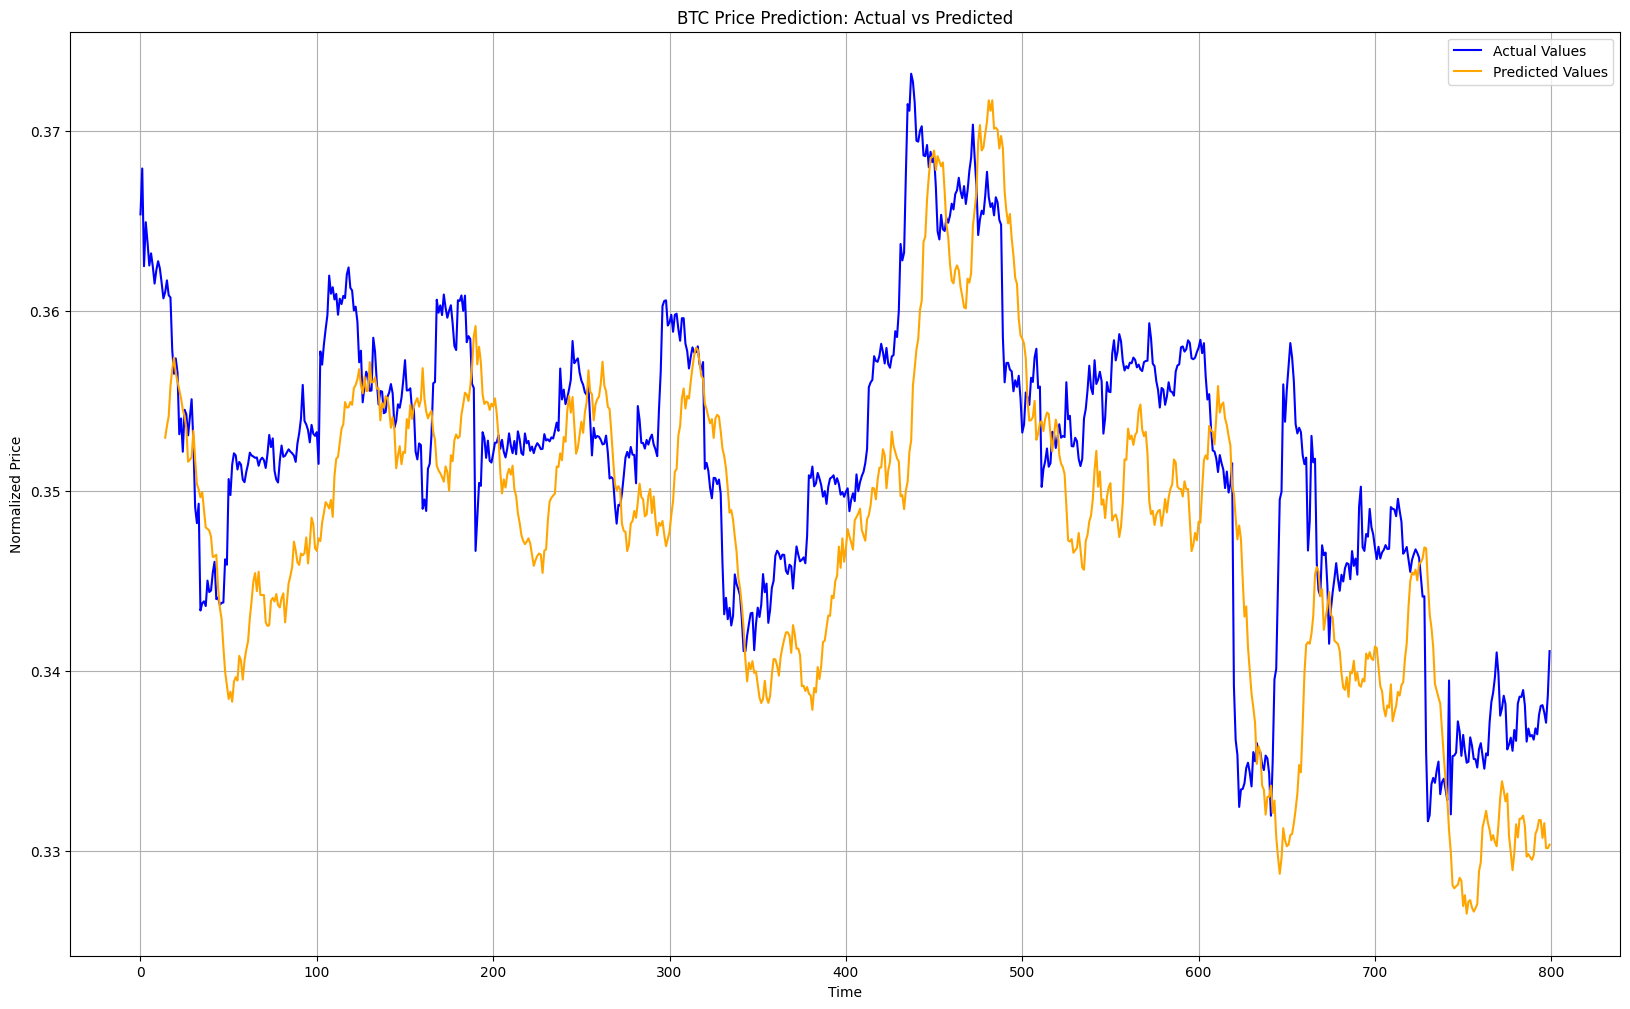

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.plot(y_test, label="Actual Values", color="blue")
plt.plot(smoothedned_y_pred, label="Predicted Values", color="orange")
plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.title("BTC Price Prediction: Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()


In [ ]:
alpha = 0.1

In [ ]:
window_ = 20
smoothened = pd.Series(y_pred).rolling()